# SAS Workbench Python API

[Online Documentation](https://go.documentation.sas.com/doc/en/workbenchcdc/2.0/explore/n1kiea90s0276wn1xr0ig0hvkix6.htm)

## Overview of the Predictive Modeling Case
A financial services company offers a home equity line of credit to its clients. The
company has extended several thousand lines of credit in the past, and many of these
accepted applicants (approximately 20%) have defaulted on their loans. By using
geographic, demographic, and financial variables, the company wants to build a model
to predict whether an applicant will default.

## Data
After analyzing the data, the company selected a subset of 12 predictor (or input)
variables to model whether each applicant defaulted. The response (or target) variable
(BAD) indicates whether an applicant defaulted on the home equity line of credit.
These variables, along with their model role, measurement level, and description, are
shown in the following table from the **HMEQ** data set.

| Name      | Model Role | Measurement Level | Description                                                            |
|:----------|:-----------|:------------------|:-----------------------------------------------------------------------|
| BAD       | Target     | Binary            | 1 = applicant defaulted on loan or delinquent, 0 = applicant paid loan |
| CLAGE     | Input      | Interval          | Age of oldest credit line in months                                    |
| CLNO      | Input      | Interval          | Number of credit lines                                                 |
| DEBTINC   | Input      | Interval          | Debt-to-income ratio                                                   |
| DELINQ    | Input      | Interval          | Number of delinquent credit lines                                      |
| DEROG     | Input      | Interval          | Number of derogatory reports                                           |
| JOB       | Input      | Nominal           | Occupational categories                                                |
| LOAN      | Input      | Interval          | Amount of loan request                                                 |
| MORTDUE   | Input      | Interval          | Amount due on existing mortgage                                        |
| NINQ      | Input      | Interval          | Number of recent credit inquiries                                      |
| REASON    | Input      | Binary            | DebtCon = debt consolidation, HomeImp = home improvement               |
| VALUE     | Input      | Interval          | Value of current property                                              |
| YOJ       | Input      | Interval          | Years at present job                                                   |

# Load Packages

In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score

import pickle
import warnings
warnings.filterwarnings('ignore')

# Load Data

In [2]:
data_path = "/workspaces/myfolder/data/hmeq.csv"

In [3]:
df = pd.read_csv(data_path)

In [4]:
target = "BAD"
nom_vars = ["JOB","REASON"]
cont_vars = [x for x in list(df) if x not in [target]+nom_vars]
all_vars = nom_vars + cont_vars

# View Data

In [5]:
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


In [6]:
df.shape

(5960, 13)

In [7]:
df.describe(include="all")

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,5960.000000,5960.000000,5442.000000,5848.000000,5708,5681,5445.000000,5252.000000,5380.000000,5652.000000,5450.000000,5738.000000,4693.000000
unique,NaN,NaN,NaN,NaN,2,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,DebtCon,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,3928,2388,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,0.199497,18607.969799,73760.817200,101776.048741,NaN,NaN,8.922268,0.254570,0.449442,179.766275,1.186055,21.296096,33.779915
std,0.399656,11207.480417,44457.609458,57385.775334,NaN,NaN,7.573982,0.846047,1.127266,85.810092,1.728675,10.138933,8.601746
min,0.000000,1100.000000,2063.000000,8000.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524499
25%,0.000000,11100.000000,46276.000000,66075.500000,NaN,NaN,3.000000,0.000000,0.000000,115.116702,0.000000,15.000000,29.140031
50%,0.000000,16300.000000,65019.000000,89235.500000,NaN,NaN,7.000000,0.000000,0.000000,173.466667,1.000000,20.000000,34.818262
75%,0.000000,23300.000000,91488.000000,119824.250000,NaN,NaN,13.000000,0.000000,0.000000,231.562278,2.000000,26.000000,39.003141


# View Nominal Variables

In [8]:
df_freq = df[target].value_counts(dropna=False)
pd.DataFrame({
    target: df_freq.index,
    "Frequency": df_freq.values,
    'Percent': ((df_freq.values/df_freq.values.sum())*100).round(2),
})

,BAD,Frequency,Percent
0,0,4771,80.05
1,1,1189,19.95


In [9]:
df_freq = df[nom_vars[0]].value_counts(dropna=False)
pd.DataFrame({
    nom_vars[0]: df_freq.index,
    "Frequency": df_freq.values,
    'Percent': ((df_freq.values/df_freq.values.sum())*100).round(2),
})

,JOB,Frequency,Percent
0,Other,2388,40.07
1,ProfExe,1276,21.41
2,Office,948,15.91
3,Mgr,767,12.87
4,NaN,279,4.68
5,Self,193,3.24
6,Sales,109,1.83


In [10]:
df_freq = df[nom_vars[1]].value_counts(dropna=False)
pd.DataFrame({
    nom_vars[1]: df_freq.index,
    "Frequency": df_freq.values,
    'Percent': ((df_freq.values/df_freq.values.sum())*100).round(2),
})

,REASON,Frequency,Percent
0,DebtCon,3928,65.91
1,HomeImp,1780,29.87
2,NaN,252,4.23


# View Continuous Data

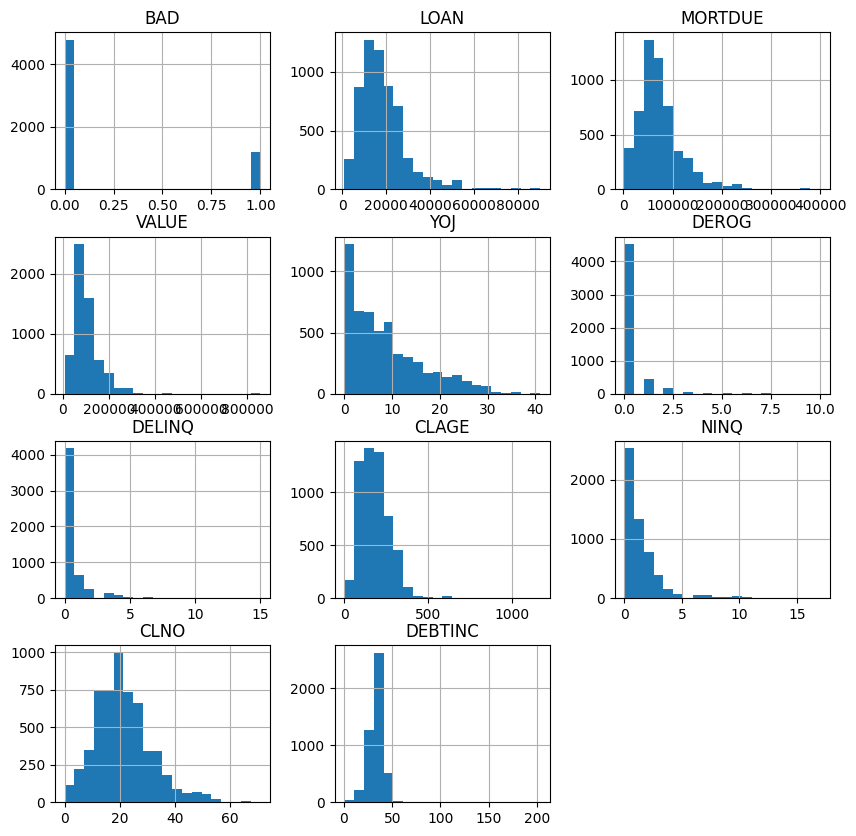

In [11]:
df.hist(bins=20, figsize=(10,10))
plt.show()

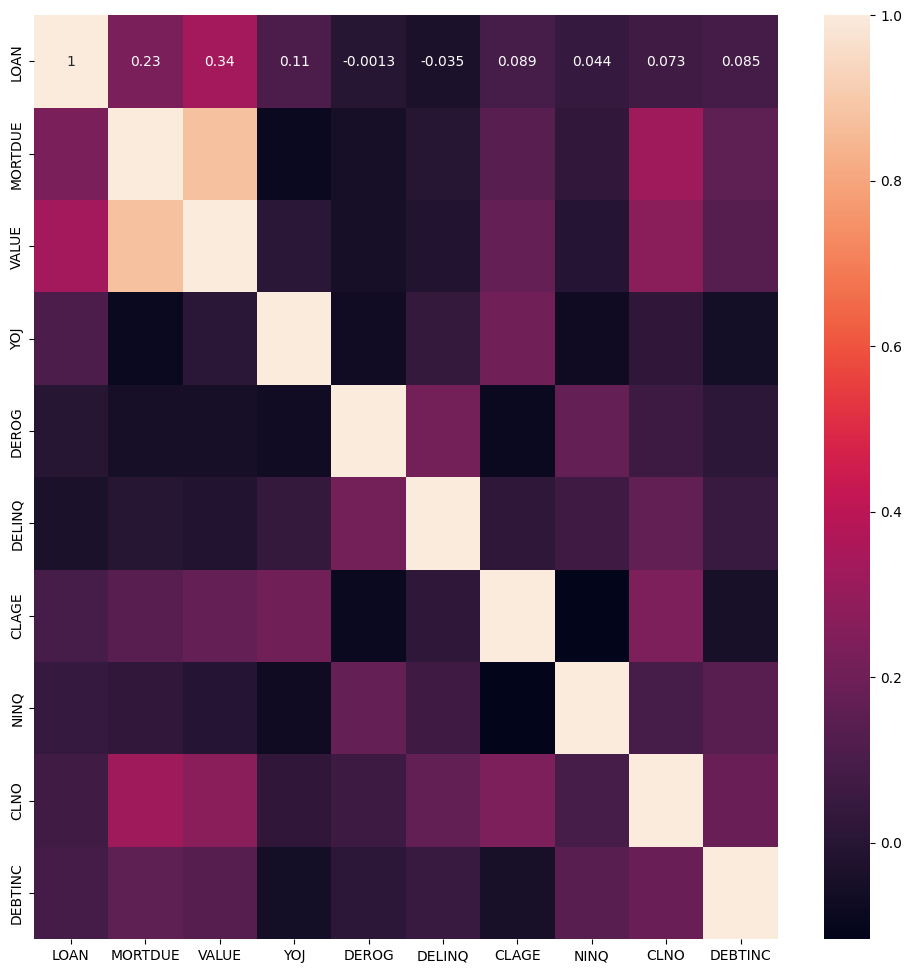

In [12]:
plt.figure(figsize=(12,12))
corr_heat = sb.heatmap(df[cont_vars].corr(), annot=True)

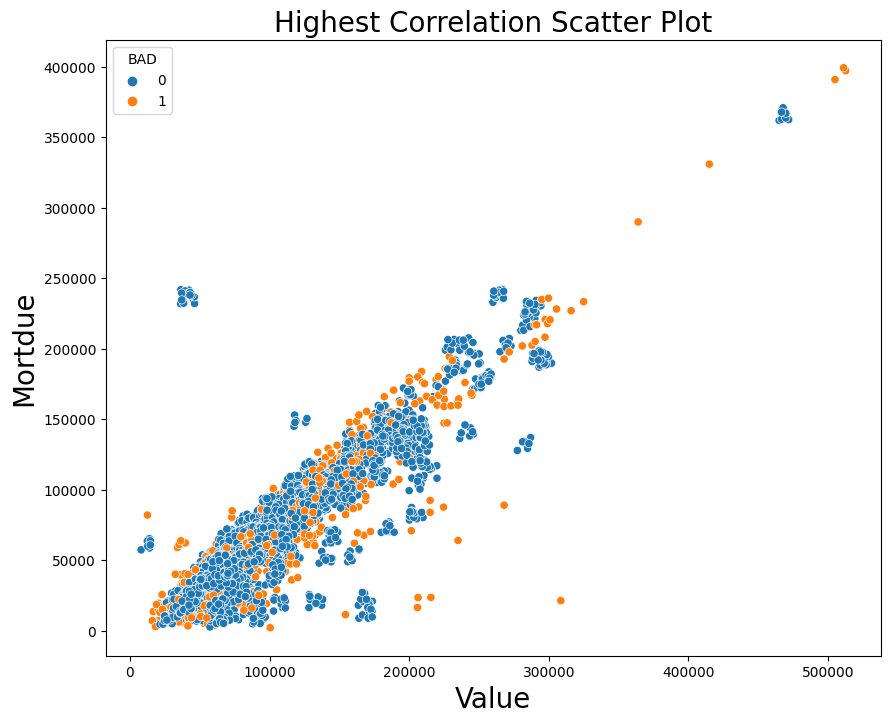

In [13]:
fig = plt.figure(figsize =(10, 8))
sb.scatterplot(data=df, x="VALUE", y="MORTDUE", hue="BAD")
plt.xlabel("Value", fontsize=20)
plt.ylabel("Mortdue", fontsize=20)
plt.title("Highest Correlation Scatter Plot", fontsize=20)
plt.show()

# Transform Data

In [14]:
TF_cols = ["LOAN", "MORTDUE", "VALUE", "CLAGE"]
for tf_col in TF_cols:
    df[tf_col] = df[tf_col+"_TF"] = np.sqrt(df[tf_col])
    df = df.drop([tf_col], axis=1)

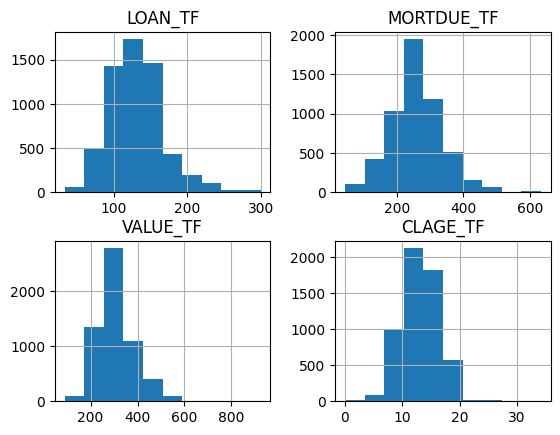

In [15]:
df[["LOAN_TF", "MORTDUE_TF", "VALUE_TF", "CLAGE_TF"]].hist()
plt.show()

In [16]:
conditions = [
    (df["YOJ"] <= 10),
    (df["YOJ"] > 10) & (df["YOJ"] <= 20),
    (df["YOJ"] > 20) & (df["YOJ"] <= 100),
    (df["YOJ"].isna())
    ]

values = ["<=10", "11-20", ">20", None]

df["YOJ_TF"] = np.select(conditions, values)

df = df.drop(["YOJ"], axis=1)

In [17]:
df_freq = df["YOJ_TF"].value_counts(dropna=False)
pd.DataFrame({
    "YOJ_TF": df_freq.index,
    "Frequency": df_freq.values,
    'Percent': ((df_freq.values/df_freq.values.sum())*100).round(2),
})

,YOJ_TF,Frequency,Percent
0,<=10,3663,61.46
1,11-20,1225,20.55
2,>20,557,9.35
3,None,515,8.64


In [18]:
nom_vars = ["JOB","REASON","YOJ_TF"]
cont_vars = [x for x in list(df) if x not in [target]+nom_vars]
all_vars = nom_vars + cont_vars

# Partition Data

In [19]:
X_train, X_valid, y_train, y_valid = train_test_split(
     df[all_vars], df[target], test_size=0.25, random_state=802)

# Impute Missing

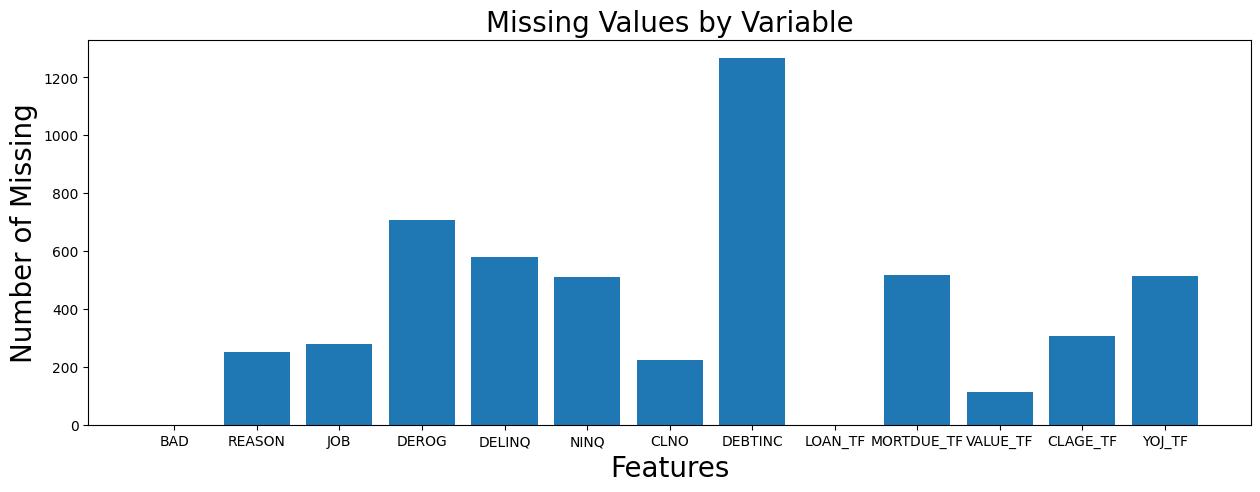

In [20]:
missing = df.isna().sum()
fig = plt.figure(figsize =(15, 5))
plt.bar(missing.index, missing.values)
plt.xlabel("Features", fontsize=20)
plt.ylabel("Number of Missing", fontsize=20)
plt.title("Missing Values by Variable", fontsize=20)
plt.show()

In [21]:
train_cont_impute = []
for var in cont_vars:
    train_cont_impute.append(X_train[var].median())
    X_train[var] = X_train[var].fillna(train_cont_impute[-1])

In [22]:
train_noms_impute = []
for var in nom_vars:
    train_noms_impute.append(X_train[var].mode()[0])
    X_train[var] = X_train[var].fillna(train_noms_impute[-1])

In [23]:
X_train.isna().sum()

JOB           0
REASON        0
YOJ_TF        0
DEROG         0
DELINQ        0
NINQ          0
CLNO          0
DEBTINC       0
LOAN_TF       0
MORTDUE_TF    0
VALUE_TF      0
CLAGE_TF      0
dtype: int64

In [24]:
i = 0
for var in cont_vars:
    X_valid[var] = X_valid[var].fillna(train_cont_impute[i])
    i=i+1

In [25]:
i = 0
for var in nom_vars:
    X_valid[var] = X_valid[var].fillna(train_noms_impute[i])
    i=i+1

In [26]:
X_valid.isna().sum()

JOB           0
REASON        0
YOJ_TF        0
DEROG         0
DELINQ        0
NINQ          0
CLNO          0
DEBTINC       0
LOAN_TF       0
MORTDUE_TF    0
VALUE_TF      0
CLAGE_TF      0
dtype: int64

# Dimension Reduction

In [27]:
rfc = RandomForestClassifier(n_estimators=250, max_depth=5, random_state=0)
rfc.fit(X_train[cont_vars],y_train)

RandomForestClassifier(max_depth=5, n_estimators=250, random_state=0)

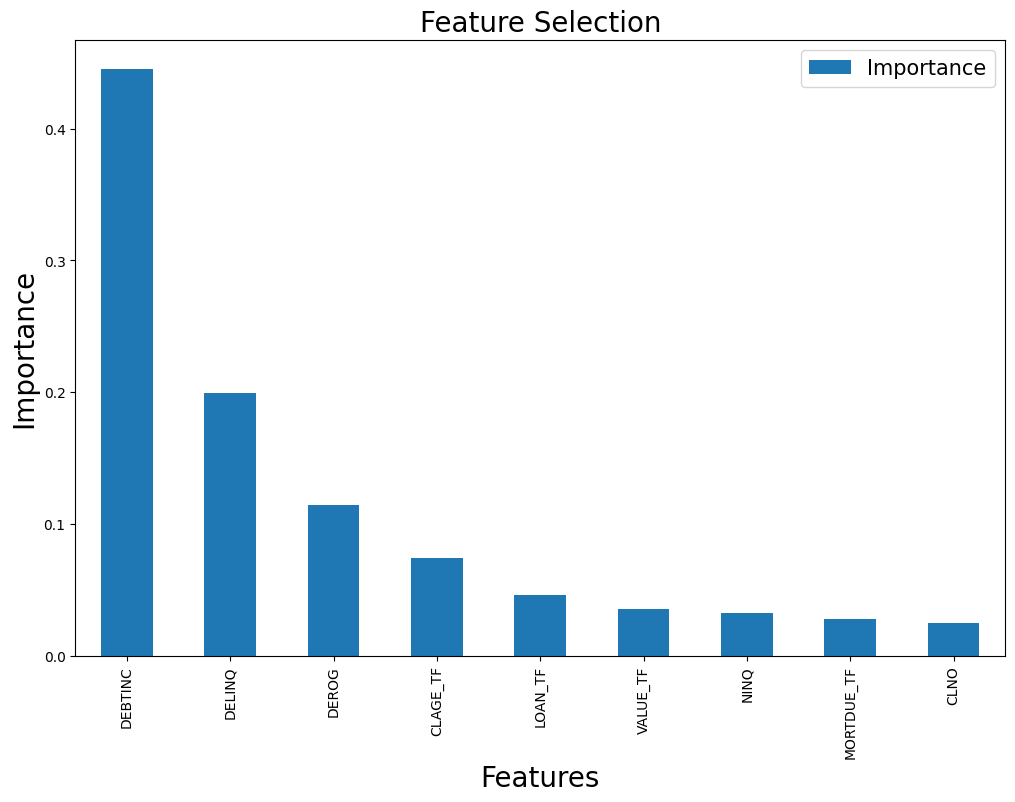

In [28]:
importance = pd.DataFrame({"Input":list(X_train[cont_vars]), "Importance":rfc.feature_importances_}).sort_values(
    by=["Importance"], ascending=False)

#plt.figure(figsize=(15, 15))
importance.plot.bar(x="Input",y="Importance",figsize=(12,8))
plt.xlabel("Features", fontsize=20)
plt.ylabel("Importance", fontsize=20)
plt.title("Feature Selection", fontsize=20)
plt.legend(loc="upper right", fontsize=15)
plt.show()

# Build Models with Sklearn

In [29]:
# dummies_train = pd.get_dummies(X_train[nom_vars])
# X_train_dummies = pd.concat([X_train, dummies_train], axis=1)
# X_train_dummies = X_train_dummies.drop(nom_vars, axis=1)

# dummies_valid = pd.get_dummies(X_valid[nom_vars])
# X_valid_dummies = pd.concat([X_valid, dummies_valid], axis=1)
# X_valid_dummies = X_valid_dummies.drop(nom_vars, axis=1)

In [30]:
# lr_mod = LogisticRegression()
# lr_mod.fit(X_train_dummies, y_train)

In [31]:
# dt_mod = DecisionTreeClassifier()
# dt_mod.fit(X_train_dummies, y_train)

In [32]:
# rf_mod = RandomForestClassifier()
# rf_mod.fit(X_train_dummies, y_train)

In [33]:
# gb_mod = GradientBoostingClassifier()
# gb_mod.fit(X_train_dummies, y_train)

# Build Models in SAS

In [34]:
from sasviya.ml.linear_model import LogisticRegression
from sasviya.ml.tree import DecisionTreeClassifier, ForestClassifier, GradientBoostingClassifier

In [35]:
lr_mod = LogisticRegression(tol=1e-8, fit_intercept=True, solver="nrridg", selection=None,
                            max_iter=50, max_time=None, verbose=0)
lr_mod.fit(X_train, y_train, nominals=nom_vars)
lr_mod.coef_

Parameter,CLAGE_TF,CLNO,DEBTINC,DELINQ,DEROG,JOB Mgr,JOB Office,JOB Other,JOB ProfExe,JOB Sales,JOB Self,LOAN_TF,MORTDUE_TF,NINQ,REASON DebtCon,REASON HomeImp,VALUE_TF,YOJ_TF 11-20,YOJ_TF <=10,YOJ_TF >20
Group,,,,,,,,,,,,,,,,,,,,
0,0.143588,0.00983,-0.073763,-0.757022,-0.588975,0.801002,1.241343,0.605316,0.542096,-0.447257,0.0,0.006071,0.002883,-0.173209,0.162846,0.0,-0.001673,-0.5197,-0.395147,0.0


In [36]:
dt_mod = DecisionTreeClassifier(criterion="IGR", max_depth=10, min_samples_leaf=5,
                                ccp_alpha=0, verbose=0)
dt_mod.fit(X_train, y_train, nominals=nom_vars)

DecisionTreeClassifier()

In [37]:
rf_mod = ForestClassifier(n_estimators=100, bootstrap=0.6, criterion="IGR", max_depth=20,
                          max_features=None, min_samples_leaf=5, n_bins=50, oob_score=True,
                          random_state=None, verbose=0)
rf_mod.fit(X_train, y_train, nominals=nom_vars)

ForestClassifier()

In [38]:
gb_mod = GradientBoostingClassifier(min_samples_leaf=5, n_bins=50, n_estimators=100, max_depth=4,
                                    max_features=None, learning_rate=0.1, subsample=0.5, l1_penalty=0,
                                    l2_penalty=1, random_state=None, verbose=0, n_iter_no_change=0,
                                    tol=0, calc_feature_importances=False, validation_fraction=0)
gb_mod.fit(X_train, y_train, nominals=nom_vars)

GradientBoostingClassifier()

# Assess Models

In [39]:
models = {"Logistic Regression":lr_mod,
          "Decision Tree":dt_mod,
          "Random Forest":rf_mod,
          "Gradient Boosting":gb_mod}

In [40]:
preds = {}
for key in models:
    preds[key] = models[key].predict(X_valid)

In [41]:
conf_mats = {}
for key in preds:
    conf_mats[key] = confusion_matrix(y_valid, preds[key]).ravel()

conf_mats["Metric"] = ["TN","FP","FN","TP"]
pd.DataFrame(conf_mats)

,Logistic Regression,Decision Tree,Random Forest,Gradient Boosting,Metric
0,1170,1187,1161,1162,TN
1,41,24,50,49,FP
2,184,184,107,92,FN
3,95,95,172,187,TP


In [42]:
acc = {}
for key in models:
    acc[key] = models[key].score(X_valid, y_valid)
    
pd.DataFrame({"Model":acc.keys(), "Accuracy":list(acc.values())}).sort_values(by="Accuracy", ascending=False)

,Model,Accuracy
3,Gradient Boosting,0.905369
2,Random Forest,0.894631
1,Decision Tree,0.860403
0,Logistic Regression,0.848993


In [43]:
probs = {}
for key in models:
    probs[key] = models[key].predict_proba(X_valid)["P_BAD1"]

In [44]:
auc = {}
fpr_tpr = {}
for key in probs:
    auc[key] = roc_auc_score(y_valid, probs[key])
    fpr_tpr[key] = roc_curve(y_valid, probs[key])

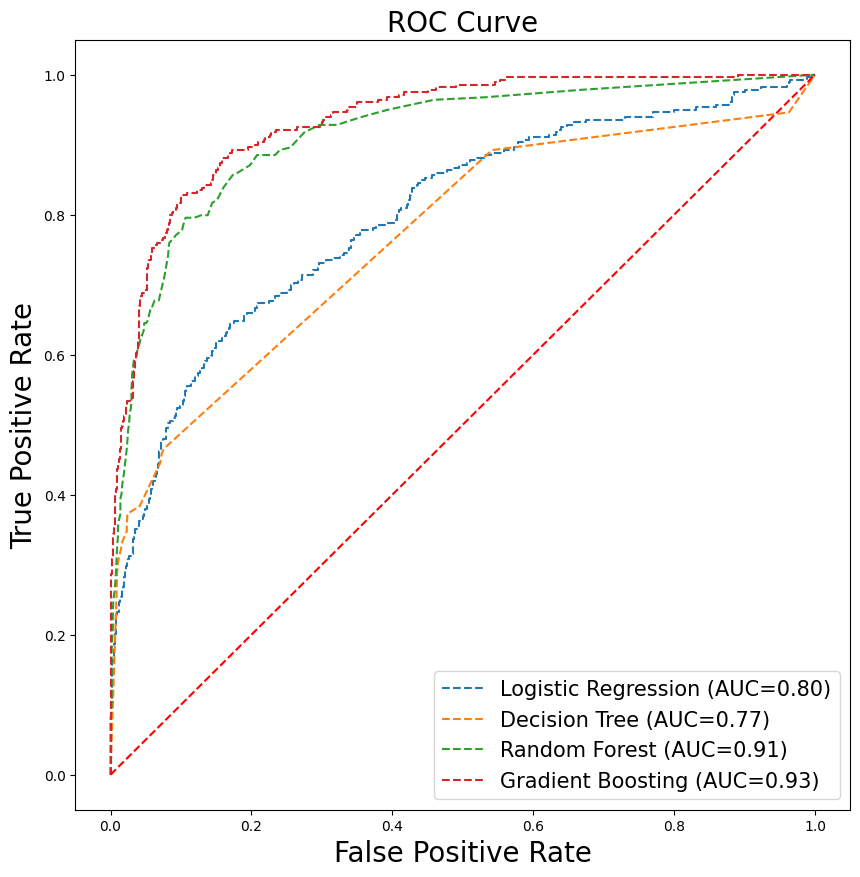

In [45]:
plt.figure(figsize = (10, 10))

for key in auc:
    plt.plot(fpr_tpr[key][0], fpr_tpr[key][1], linestyle='--', label=key+" (AUC=%0.2f)"%(auc[key]))

plt.plot([0, 1], [0, 1],'r--')
plt.xlabel("False Positive Rate", fontsize = 20)
plt.ylabel("True Positive Rate", fontsize = 20)
plt.title("ROC Curve", fontsize = 20)
plt.legend(loc="lower right", fontsize = 15)
plt.show()

# Pickle Export

In [46]:
file = open("gb_model.pickle", 'wb')
pickle.dump(gb_mod, file)
file.close()

In [47]:
# file = open("gb_model.pickle",'rb')
# gb_mod = pickle.load(file)
# file.close()

# Astore Export

In [48]:
gb_mod.export(file="gb_model.astore", replace=True)